In [1]:
%load_ext autoreload
%autoreload 2
%precision %e

import logging
import os.path

# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import seaborn as sns
from IPython.utils import io
import scipy.sparse as sp

from atlite import Cutout
import rioxarray

working_directory = os.path.dirname(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
)
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

logger = logging.getLogger(__name__)

In [2]:
import logging

import atlite
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr


os.chdir(scripts_dir)

from _helpers import configure_logging, mock_snakemake
from constants import PROV_NAMES
from readers import read_generic_province_data

os.chdir(root_dir)

snakemake = mock_snakemake(
    "build_population_layouts",
)


/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pulp/apis/gurobi_api.py:238: UserWarning: GUROBI error: License expired 2025-10-17.
  warnings.warn(f"GUROBI error: {e}.")
/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pulp/apis/gurobi_api.py:443: UserWarning: GUROBI error: Set parameter LogFile to value "gurobi.log"
Using license file /home/ivanra/gurobi.lic

Failed to set up a license

Error 10009: License expired 2025-10-17


.
  warnings.warn(f"GUROBI error: {out}.")


resources/data/population/china_world_pop_2024-2024-1-B.tif
https://data.worldpop.org/GIS/Population/Global_2015_2030/R2024B/2024/CHN/v1/1km_ua/constrained/


In [3]:
# SPDX-FileCopyrightText: Contributors to PyPSA-Eur <https://github.com/pypsa/pypsa-eur>
#
# SPDX-License-Identifier: MIT
"""
Build mapping between cutout grid cells and population (total, urban, rural).
"""



province_shapes = gpd.read_file(snakemake.input.province_shape).set_index("province")
pop_year = snakemake.params.pop_year
cutout = atlite.Cutout(snakemake.input.cutout)
grid_cells = cutout.grid.geometry

# Indicator matrix province -> grid cells
I = atlite.cutout.compute_indicatormatrix(province_shapes.geometry, grid_cells)  # noqa: E741

# Indicator matrix grid_cells -> prov; inprinciple Iinv*I is identity
# but imprecisions mean not perfeprov
Iinv = cutout.indicatormatrix(province_shapes.geometry)

provinces = np.sort(province_shapes.index.unique())
if not (sorted(PROV_NAMES) == provinces).all():
    raise ValueError(f"Province columns of {snakemake.input.province_shape} do not match expected names.")

population_provs = read_generic_province_data(
    snakemake.input.province_populations, index_col=0, index_name="province")
population_provs = population_provs[str(pop_year)]*snakemake.params.pop_conversion
if not population_provs.sum() > 1e9:
    logger.warning("Low population count, check headcount conversion")

urban_frac = read_generic_province_data(snakemake.input.urban_percent, index_col=0, index_name="province")
urban_frac = urban_frac[str(pop_year)]/100

# Create prov_data GeoDataFrame AFTER reading urban_frac
prov_data = gpd.GeoDataFrame(
    {
        "geometry": province_shapes.geometry,
        "population": population_provs,
        "urban_fraction": urban_frac,
    },
    crs=province_shapes.crs.to_string(),
)

# population in each grid cell
pop_cells = pd.Series(I.dot(population_provs))

# in km^2
cell_areas = grid_cells.to_crs(3035).area / 1e6

# pop per km^2
density_cells = pop_cells / cell_areas

# rural or urban population in grid cell
pop_rural = pd.Series(0.0, density_cells.index)
pop_urban = pd.Series(0.0, density_cells.index)


/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/geopandas/geoseries.py:772: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


In [4]:

for prov in provinces:
    logger.debug(
        f"The urbanization rate for {prov} is {round(urban_frac[prov] * 100)}%"
    )

    indicator_prov = prov_data.apply(lambda x: 1.0 if x.name == prov else 0.0, axis=1)

    indicator_cells_prov = pd.Series(Iinv.T.dot(indicator_prov))

    density_cells_prov = indicator_cells_prov * density_cells

    pop_cells_prov = indicator_cells_prov * pop_cells

    # correprov for imprecision of Iinv*I
    pop_prov = prov_data.loc[prov, "population"].sum()
    if pop_cells_prov.sum() != 0:
        pop_cells_prov *= pop_prov / pop_cells_prov.sum()

    # The first low density grid cells to reach rural fraprovion are rural
    asc_density_i = density_cells_prov.sort_values().index
    asc_density_cumsum = (
        pop_cells_prov.iloc[asc_density_i].cumsum() / pop_cells_prov.sum()
    )
    rural_fraprovion_prov = 1 - urban_frac[prov]
    pop_prov_rural_b = asc_density_cumsum < rural_fraprovion_prov
    pop_prov_urban_b = ~pop_prov_rural_b

    pop_prov_rural_b[indicator_cells_prov == 0.0] = False
    pop_prov_urban_b[indicator_cells_prov == 0.0] = False

    pop_rural += pop_cells_prov.where(pop_prov_rural_b, 0.0)
    pop_urban += pop_cells_prov.where(pop_prov_urban_b, 0.0)

pop_cells = {"total": pop_cells}
pop_cells["rural"] = pop_rural
pop_cells["urban"] = pop_urban

for key, pop in pop_cells.items():
    ycoords = ("y", cutout.coords["y"].data)
    xcoords = ("x", cutout.coords["x"].data)
    values = pop.values.reshape(cutout.shape)
    layout = xr.DataArray(values, [ycoords, xcoords])

In [5]:
import cartopy.crs as ccrs


In [6]:
def log_plot(ds: xr.DataArray, label: str = "", ax = None, min_val = 1e-1, cmap = "viridis", fillna = None):

    # Create a figure with proper size
    if ax is None:
        print("making new ax")
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    min_ = ds.values[ds.values > 0].min()
    min_ = max(min_, min_val)

    if fillna is not None:
        ds = ds.fillna(fillna)

    # Plot with log scale and colorbar
    im = ds.plot(ax=ax, 
                    norm=LogNorm(vmin=min_, vmax=ds.values.max()),
                    cmap=cmap,
                    add_colorbar=False,
                    alpha = 0.9)

    # Add a colorbar with log scale
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label( label, rotation=270, labelpad=20)

    # Set title and labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    fig = ax.get_figure()
    fig.tight_layout()


# Investigate pypsa-europe approach
conclusion partially fills cells based on urban fraction (intended to work at admin level 2)

In [7]:

PLOT_PYPSA_EUR_METHOD  = False
if PLOT_PYPSA_EUR_METHOD:

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    province_shapes.plot(ax = axes[0], facecolor='none', edgecolor='black')
    ds_tot = xarray.open_dataarray("resources/derived_datapop_layout_total.nc")
    log_plot(ds_tot, ax=axes[0])

    province_shapes.plot(ax=axes[1], facecolor='none', edgecolor='black')
    ds_rural = xarray.open_dataarray("resources/derived_datapop_layout_rural.nc")
    log_plot(ds_rural, ax=axes[1])
    axes[1].set_title("Rural Population")

    province_shapes.plot(ax=axes[2],  facecolor='none', edgecolor='black')
    ds_urban = xarray.open_dataarray("resources/derived_datapop_layout_urban.nc")
    log_plot(ds_urban, ax=axes[2])
    axes[2].set_title("Urban Population")




In [8]:
high_res_pop = rioxarray.open_rasterio(snakemake.input.population_gridded).assign_coords(band=["population"])


# Set missing value to 0
high_res_pop = high_res_pop.clip(0)
high_res_pop.attrs["_FillValue"] = 0
high_res_pop


<xarray.DataArray (band: 1, y: 4534, x: 7353)> Size: 133MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) <U10 40B 'population'
  * y            (y) float64 36kB 53.55 53.55 53.54 53.53 ... 15.8 15.79 15.78
  * x            (x) float64 59kB 73.5 73.51 73.52 73.53 ... 134.8 134.8 134.8
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      sum

In [9]:
import scipy.sparse as sp


In [10]:

# Alternative even faster approach using rasterization
def create_rasterized_indicator_matrix(ds, province_shapes, ds_crs=None):
    """
    Ultra-fast approach using rasterization - converts province polygons to raster masks.
    
    Parameters:
    - ds: xarray DataArray with x, y coordinates  
    - province_shapes: GeoDataFrame with province geometries
    - ds_crs: CRS of the dataset (required if ds doesn't have .crs attribute)
    """
    from rasterio import features
    from affine import Affine
    
    # Handle CRS - check if ds has crs attribute, otherwise use provided ds_crs
    if hasattr(ds, 'crs') and ds.crs is not None:
        data_crs = ds.crs
    elif ds_crs is not None:
        data_crs = ds_crs
    else:
        # Default to WGS84 if no CRS provided
        data_crs = 'EPSG:4326'
        print(f"Warning: No CRS found for dataset, assuming {data_crs}")
    
    # Get grid parameters
    height, width = ds.shape
    x_coords = ds.coords["x"].values
    y_coords = ds.coords["y"].values
    
    # Calculate transform (affine transformation matrix)
    x_res = (x_coords.max() - x_coords.min()) / (len(x_coords) - 1)
    y_res = (y_coords.max() - y_coords.min()) / (len(y_coords) - 1)
    transform = Affine.translation(x_coords.min() - x_res/2, y_coords.max() + y_res/2) * Affine.scale(x_res, -y_res)
    
    # Ensure province_shapes is in the same CRS as the data
    if str(province_shapes.crs) != str(data_crs):
        print(f"Converting province shapes from {province_shapes.crs} to {data_crs}")
        province_shapes_proj = province_shapes.to_crs(data_crs)
    else:
        province_shapes_proj = province_shapes
    
    n_provinces = len(province_shapes_proj)
    indicator_arrays = []
    
    print(f"Rasterizing {n_provinces} provinces...")
    
    for prov_idx, (prov_name, prov_geom) in enumerate(province_shapes_proj.geometry.items()):
        # Rasterize this province
        province_mask = features.rasterize(
            [(prov_geom, 1)],
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype=np.uint8
        )
        
        # Flatten and store
        indicator_arrays.append(province_mask.ravel())
        
        if prov_idx % 5 == 0:
            print(f"Rasterized {prov_idx+1}/{n_provinces} provinces")
    
    # Stack all province masks
    indicator_matrix = np.column_stack(indicator_arrays)
    
    # Convert to sparse for memory efficiency
    indicator_matrix = sp.csr_matrix(indicator_matrix)
    
    # Create grid coordinates
    xs, ys = np.meshgrid(x_coords, y_coords)
    grid_coords = np.column_stack([xs.ravel(), ys.ravel()])
    
    print(f"Created rasterized indicator matrix with shape {indicator_matrix.shape}")
    
    return indicator_matrix, grid_coords

In [11]:
# Example usage and comparison
import time


def land_fraction(indicator_matrix, prov_shape):
    """Calculate land fraction per province from indicator matrix."""

    fraction = (indicator_matrix.sum(axis=0) / indicator_matrix.sum() * 100)
    fraction = np.asarray(fraction).ravel()
    res = {}
    for i, prov in enumerate(prov_shape.index):
        res[prov] = fraction[i]
    res["tot"] = fraction.sum()
    return res


# Check CRS of our datasets
print("Dataset CRS information:")
print(f"Province shapes CRS: {province_shapes.crs}")
print(f"High res pop has crs attribute: {hasattr(high_res_pop, 'crs')}")
if hasattr(high_res_pop, 'crs'):
    print(f"High res pop CRS: {high_res_pop.crs}")

# For high_res_pop (rioxarray), it should have a CRS
# For interpolated_data, it might not have CRS, so we'll use the cutout's CRS
cutout_crs = cutout.crs  # This should be available from Atlite
print(f"Cutout CRS: {cutout_crs}")

# Method 1: Rasterized approach (fastest) - use high_res_pop which has CRS
print("\n=== Testing Rasterized Approach ===")
start_time = time.time()
I_fast, coords_fast = create_rasterized_indicator_matrix(high_res_pop.squeeze(), province_shapes)
raster_time = time.time() - start_time
print(f"Rasterized approach took: {raster_time:.2f} seconds")


# Example: Calculate population per province using the new indicator matrix
if 'population_provs' in locals():
    # Use high_res_pop data directly (before interpolation to cutout grid)
    pop_per_cell_highres = high_res_pop.values.ravel()
    pop_per_province_fast = I_fast.T @ pop_per_cell_highres  # Matrix multiplication
    

    
    # Compare with original PyPSA approach
    print(f"\nTotal from high-res method: {pop_per_province_fast.sum():,.0f}")
    print(f"Total from original method: {population_provs.sum():,.0f}")



Dataset CRS information:
Province shapes CRS: EPSG:4326
High res pop has crs attribute: False
Cutout CRS: EPSG:4326

=== Testing Rasterized Approach ===
Rasterizing 31 provinces...
Rasterized 1/31 provinces
Rasterized 6/31 provinces
Rasterized 11/31 provinces
Rasterized 16/31 provinces
Rasterized 21/31 provinces
Rasterized 26/31 provinces
Rasterized 31/31 provinces
Created rasterized indicator matrix with shape (33338502, 31)
Rasterized approach took: 15.65 seconds

Total from high-res method: 1,410,485,504
Total from original method: 1,409,750,000


In [12]:
# interpolated_data = high_res_pop.interp_like(cutout.data)

# # Squeeze to remove unnecessary dimensions (like single band dimension)
# interpolated_data = interpolated_data.squeeze()

# print(f"Interpolated data shape after squeeze: {interpolated_data.shape}")
# print(f"Interpolated data dims after squeeze: {interpolated_data.dims}")

    
# # Also test with interpolated data (pass explicit CRS)
# I_interp, coords_interp = create_rasterized_indicator_matrix(
#     interpolated_data, province_shapes, ds_crs=cutout_crs
# )
# pop_per_cell_interp = interpolated_data.values.ravel()
# pop_per_province_interp = I_interp.T @ pop_per_cell_interp


In [13]:
# land_frac_fast = land_fraction(I_fast, province_shapes)
# land_frac_interp = land_fraction(I_interp, province_shapes)
# res = {}
# nnz = I.nnz
# sum_= 0
# for i, prov in enumerate(province_shapes.index):
#     res[prov] = I[:,i].nnz/nnz*100
#     sum_ +=  I[:,i].nnz
# # res["tot"] = sum_/I.nnz*100

# land_frac_atlite = res

# pd.DataFrame({"atlite":land_frac_atlite, "interp": land_frac_interp, "fast": land_frac_fast})

In [14]:
PLOT_HIGHRES = False
if PLOT_HIGHRES:
    values = pop_per_cell_highres.reshape(high_res_pop.shape).squeeze()
    ycoords = ("y", high_res_pop.coords["y"].data)
    xcoords = ("x", high_res_pop.coords["x"].data)
    layout = xr.DataArray(values, [ycoords, xcoords])

    fig, ax = plt.subplots(figsize=(12, 8))
    log_plot(layout, ax=ax)
    province_shapes.plot(ax=ax, facecolor="none", edgecolor="black")

## Compare the indicator matrix cells
- conclusion: better res works better with much faster implementation than ATLITE


In [15]:
CHECK_ASSIGNMENT = False

In [16]:
if CHECK_ASSIGNMENT:

    # Visualize grid cells assigned to each province
    fig, ax = plt.subplots(figsize=(14, 10))

    # I matrix is (provinces x grid_cells), find max province for each cell
    I_dense = I.T.toarray()  # Convert to dense for easier indexing
    cell_assignment = np.argmax(I_dense, axis=0)  # Get province index for each cell
    cell_assignment = np.where(I_dense.sum(axis=0) > 0, cell_assignment + 1, 0)  # +1 for coloring, 0 for no province

    # Reshape to grid
    grid_colors = cell_assignment.reshape(cutout.shape)

    # Plot cells colored by province
    im = ax.imshow(grid_colors, cmap='tab20c', aspect='auto', origin='lower', 
                extent=[cutout.coords['x'].min(), cutout.coords['x'].max(),
                        cutout.coords['y'].min(), cutout.coords['y'].max()], 
                        alpha =0.5)

    # Overlay province boundaries
    province_shapes.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)

    ax.set_title('Grid Cells by Province [atlite]', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.show()


In [17]:
if CHECK_ASSIGNMENT:

    # Visualize grid cells assigned to each province
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # I matrix is (provinces x grid_cells), find max province for each cell
    I_dense = I_fast.T.toarray()  # Convert to dense for easier indexing
    cell_assignment = np.argmax(I_dense, axis=0) # Get province index for each cell
    cell_assignment = np.where(I_dense.sum(axis=0) > 0, cell_assignment + 1, 0)  # +1 for coloring, 0 for no province

    # Reshape to grid
    grid_colors = cell_assignment.reshape(high_res_pop.squeeze().shape)[::-1,:] 

    # Plot cells colored by province
    im = ax.imshow(grid_colors, cmap='tab20c', aspect='auto', origin='lower', 
                extent=[high_res_pop.coords['x'].min(), high_res_pop.coords['x'].max(),
                        high_res_pop.coords['y'].min(), high_res_pop.coords['y'].max()])

    # Overlay province boundaries
    province_shapes.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)

    ax.set_title('Grid Cells by Province [high res + rasterize]', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.show()


In [18]:
if CHECK_ASSIGNMENT:
    # Visualize grid cells assigned to each province
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # I matrix is (provinces x grid_cells), find max province for each cell
    I_dense = I_interp.T.toarray()  # Convert to dense for easier indexing
    cell_assignment = np.argmax(I_dense, axis=0) # Get province index for each cell
    cell_assignment = np.where(I_dense.sum(axis=0) > 0, cell_assignment + 1, 0)  # +1 for coloring, 0 for no province

    # Reshape to grid
    grid_colors = cell_assignment.reshape(cutout.shape)[::-1,:] 

    # Plot cells colored by province
    im = ax.imshow(grid_colors, cmap='tab20c', aspect='auto', origin='lower', 
                extent=[cutout.coords['x'].min(), cutout.coords['x'].max(),
                        cutout.coords['y'].min(), cutout.coords['y'].max()])

    # Overlay province boundaries
    province_shapes.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)

    ax.set_title('Grid Cells by Province [cutout res + rasterize]', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.show()


# work out populations

In [19]:
I_dense = I_fast.T.toarray()  # Convert to dense for easier indexing
cell_assignment = np.argmax(I_dense, axis=0) # Get province index for each cell
cell_assignment = np.where(I_dense.sum(axis=0) > 0, cell_assignment, -1)  # for coloring, -1 for no province
inv = cell_assignment.reshape(high_res_pop.squeeze().shape)


In [20]:
data = high_res_pop.assign_coords(band=["population"])
assignment_band = xr.DataArray(
    inv[np.newaxis, :, :],  # Add band dimension
    coords={
        'band': ["prov_index"],
        'y': data.coords['y'],
        'x': data.coords['x']
    },
    dims=['band', 'y', 'x']
)
data_with_assignment = xr.concat([data, assignment_band], dim='band')
del assignment_band
del inv

In [21]:
def rescale_population_by_province(data_with_assignment, prov_data):
    """
    Rescale population values to match expected provincial totals.
    
    Parameters:
    - data_with_assignment: xarray DataArray with bands ["population", "prov_index"]
    - expected_totals_by_prov: pd.Series or array with expected population per province (indexed 0-30)
    
    Returns:
    - xarray DataArray with rescaled population band
    """
    # Extract the bands
    pop_data = data_with_assignment.sel(band="population")
    prov_idx = data_with_assignment.sel(band="prov_index")
    
    # Calculate current totals per province (vectorized using groupby equivalent)
    # Create a flat version for fast computation
    pop_flat = pop_data.values.ravel()
    prov_flat = prov_idx.values.ravel()
    
    # Calculate scaling factors for each province
    scaling_factors = np.zeros(len(prov_data))
    for i, prov in enumerate(prov_data.index):
        mask = prov_flat == i
        raster_total = pop_flat[mask].sum()
        if raster_total > 0:
            scaling_factors[i] = prov_data.iloc[i].population / raster_total
        else:
            scaling_factors[i] = 0.0
    
    # Apply scaling factors using vectorized indexing
    # Map province index to scaling factor
    scaling_map = scaling_factors[prov_flat.astype(int)]
    
    # Rescale population
    pop_rescaled_flat = pop_flat * scaling_map
    
    # Reshape back to original shape
    pop_rescaled = pop_rescaled_flat.reshape(pop_data.shape)
    
    # Create new DataArray with rescaled population
    pop_rescaled_da = xr.DataArray(
        pop_rescaled,
        coords=pop_data.coords,
        dims=pop_data.dims
    )
    
    # Replace population band
    result = data_with_assignment.copy()
    result.loc[dict(band="population")] = pop_rescaled_da
    
    return result




In [22]:
# pop_data = data_with_assignment.sel(band="population")
# prov_idx = data_with_assignment.sel(band="prov_index")

# # Calculate current totals per province (vectorized using groupby equivalent)
# # Create a flat version for fast computation
# pop_flat = pop_data.values.ravel()
# prov_flat = prov_idx.values.ravel()
# is_rural = np.zeros_like(pop_flat, dtype=bool) 

# cut_off_populations = np.zeros(len(prov_data))
# cut_off_idxs = np.zeros(len(prov_data), dtype=int)

# # Calculate scaling factors for each province
# scaling_factors = np.zeros(len(prov_data))
# for i, prov in enumerate(prov_data.index):
#     mask = prov_flat == i
#     raster_total = pop_flat[mask].sum()
#     if raster_total > 0:
#         scaling_factors[i] = prov_data.iloc[i].population / raster_total
#     else:
#         scaling_factors[i] = 0.0

#     sorted_vals = np.sort(pop_flat[mask])
#     pop_rural = prov_data.iloc[i].population * (1-prov_data.iloc[i].urban_fraction)
#     cut_off_idx = (sorted_vals.cumsum() < pop_rural).sum()
#     is_rural[mask] = (pop_flat[mask] <= sorted_vals[cut_off_idx])

#     cut_off_populations[i] = sorted_vals[cut_off_idx]
#     cut_off_idxs[i] = cut_off_idx

# # Apply scaling factors using vectorized indexing
# # Map province index to scaling factor
# scaling_map = scaling_factors[prov_flat.astype(int)]

# # Rescale population
# pop_rescaled_flat = pop_flat * scaling_map

# # Reshape back to original shape
# pop_rescaled = pop_rescaled_flat.reshape(pop_data.shape)

# # Create new DataArray with rescaled population
# pop_rescaled_da = xr.DataArray(
#     pop_rescaled,
#     coords=pop_data.coords,
#     dims=pop_data.dims
# )


# # create rural layer
# rural = xr.DataArray(
#     is_rural.reshape(pop_data.shape),
#     coords=pop_data.coords,
#     dims=pop_data.dims
# ).expand_dims("band").assign_coords(band=["is_rural"])


In [23]:

def calculate_cell_areas(data: xr.DataArray) -> np.ndarray:
    """Calculate area of each grid cell in km^2 for lat/lon grid.
    
    Args:
        data (xr.DataArray): Data with x (longitude) and y (latitude) coordinates.
    
    Returns:
        np.ndarray: Flattened array of cell areas in km^2.
    """
    # Get coordinates
    x_coords = data.coords["x"].values
    y_coords = data.coords["y"].values
    
    # Calculate resolution
    x_res = (x_coords.max() - x_coords.min()) / (len(x_coords) - 1)
    y_res = (y_coords.max() - y_coords.min()) / (len(y_coords) - 1)
    
    # Create meshgrid for lat/lon
    lon_grid, lat_grid = np.meshgrid(x_coords, y_coords)
    
    # Calculate area using spherical Earth approximation
    # Area = (lat_spacing * R) * (lon_spacing * R * cos(lat))
    R_earth = 6371.0  # km
    lat_rad = np.deg2rad(lat_grid)
    cell_area_km2 = (np.deg2rad(y_res) * R_earth) * (np.deg2rad(x_res) * R_earth * np.cos(lat_rad))
    
    return cell_area_km2.ravel()


def correct_prov_totals_find_rural(assigned_data: xr.DataArray, prov_data: pd.DataFrame | gpd.GeoDataFrame) -> tuple[xr.DataArray, pd.DataFrame]:
    """Rescale population values to match expected provincial totals and identify rural cells.

    Args:
        assigned_data (xr.DataArray): pop data with shape_id assignment: bands=["population", "prov_index"].
        prov_data (pd.DataFrame | gpd.GeoDataFrame): Expected population per province (e.g. indexed 0-30).

    Returns:
        tuple[xr.DataArray, pd.DataFrame]: 
            - DataArray with population band rescaled and rural band added
            - DataFrame with cut-off statistics per province
    """
    # Get the bands
    pop_data = assigned_data.sel(band="population")
    prov_idx = assigned_data.sel(band="prov_index")
    
    # Create flat arrays for fast computation
    pop_flat = pop_data.values.ravel()
    prov_flat = prov_idx.values.ravel()
    
    # Calculate cell areas once
    cell_area_flat = calculate_cell_areas(assigned_data)
    
    # Initialize rural bool and tracking arrays
    is_rural = np.zeros_like(pop_flat, dtype=bool)
    cut_off_stats = []
    scaling_factors = np.zeros(len(prov_data))
    
    # Process each province
    for i, prov in enumerate(prov_data.index):
        mask = prov_flat == i
        raster_total = pop_flat[mask].sum()
        
        # Calculate scaling factor
        if raster_total > 0:
            scaling_factors[i] = prov_data.iloc[i].population / raster_total
        else:
            scaling_factors[i] = 0.0
        
        # Get province-specific values and sort by population
        prov_pop_vals = pop_flat[mask]*scaling_factors[i]
        prov_areas = cell_area_flat[mask]
        sort_indices = np.argsort(prov_pop_vals)
        sorted_pop = prov_pop_vals[sort_indices]
        sorted_areas = prov_areas[sort_indices]
        
        # Find rural cut-off
        pop_rural = prov_data.iloc[i].population * (1 - prov_data.iloc[i].urban_fraction)
        cut_off_idx = (sorted_pop.cumsum() < pop_rural).sum()
        
        # Mark rural cells
        is_rural[mask] = (prov_pop_vals <= sorted_pop[cut_off_idx-1])
        
        # Get cut-off cell statistics
        if cut_off_idx < len(sorted_pop):
            cut_off_pop = sorted_pop[cut_off_idx]
            cut_off_area = sorted_areas[cut_off_idx]
            cut_off_density = cut_off_pop / cut_off_area
        else:
            cut_off_pop = 0.0
            cut_off_area = 0.0
            cut_off_density = 0.0
        
        cut_off_stats.append({
            'province': prov,
            'cut_off_idx': cut_off_idx,
            "rural pop_ks": int(pop_rural/1e3),
            "pop_ks": int(prov_data.iloc[i].population/1e3),
            "rural fraction": 1 - prov_data.iloc[i].urban_fraction,
            'cut_off_population': int(cut_off_pop),
            'cut_off_area_km2': cut_off_area,
            'cut_off_density_per_km2': cut_off_density,
            'n_cells_province': mask.sum(),
            'n_cells_rural': is_rural[mask].sum(),
            'rural_fraction_cells': is_rural[mask].sum() / mask.sum() if mask.sum() > 0 else 0.0
        })
    
    # Convert to DataFrame
    cut_off_df = pd.DataFrame(cut_off_stats)
    
    # Rescale population using scaling factors
    scaling_map = scaling_factors[prov_flat.astype(int)]
    pop_rescaled_flat = pop_flat * scaling_map
    pop_rescaled = pop_rescaled_flat.reshape(pop_data.shape)
    
    # Create new DataArray with rescaled population
    pop_rescaled_da = xr.DataArray(
        pop_rescaled,
        coords=pop_data.coords,
        dims=pop_data.dims
    )
    
    # Create rural layer
    rural = xr.DataArray(
        is_rural.reshape(pop_data.shape),
        coords=pop_data.coords,
        dims=pop_data.dims
    ).expand_dims("band").assign_coords(band=["is_rural"])
    
    # Replace population band and add rural band
    result = assigned_data.copy()
    result.loc[dict(band="population")] = pop_rescaled_da
    
    return xr.concat([result, rural], dim='band'), cut_off_df


data_corrected, cut_off_stats = correct_prov_totals_find_rural(data_with_assignment, prov_data)


In [24]:
cut_off_stats

,province,cut_off_idx,rural pop_ks,pop_ks,rural fraction,cut_off_population,cut_off_area_km2,cut_off_density_per_km2,n_cells_province,n_cells_rural,rural_fraction_cells
0,Anhui,177617,24416,61270,0.3985,638,0.722380,883.611483,192339,177617,0.923458
1,Beijing,19937,2714,21840,0.1243,1018,0.654165,1556.940886,24770,19937,0.804885
2,Chongqing,102902,9330,32130,0.2904,572,0.745990,767.515501,110978,102902,0.927229
3,Fujian,151801,12517,41880,0.2989,1866,0.781193,2389.151963,156849,151801,0.967816
4,Gansu,595423,11415,24920,0.4581,1418,0.709913,1998.829114,598327,595423,0.995146
5,Guangdong,210736,31908,126570,0.2521,2208,0.789175,2799.043850,223213,210736,0.944103
6,Guangxi,294900,22383,50470,0.4435,915,0.798176,1146.558292,302892,294900,0.973614
7,Guizhou,223973,17425,38560,0.4519,1165,0.777948,1498.278803,228982,223973,0.978125
8,Hainan,40507,3954,10270,0.3851,1153,0.808103,1427.088348,41841,40507,0.968117
9,Hebei,266572,28455,74200,0.3835,945,0.677342,1395.670055,285262,266572,0.934481


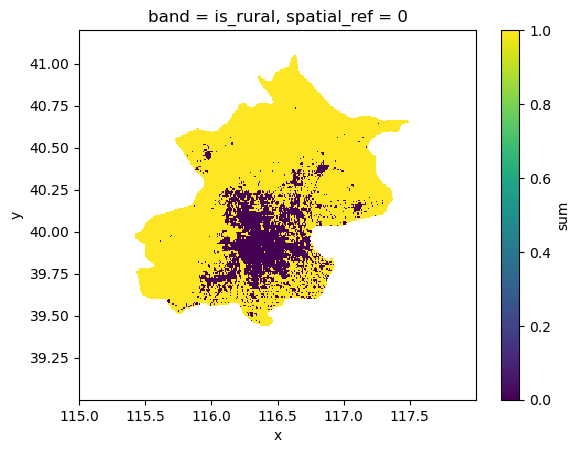

In [25]:
ds = data_corrected.sel(x=slice(115, 118), y=slice(41.2, 39)).where(data_corrected.sel(band="prov_index") ==1).sel(band="is_rural")
fig, ax = plt.subplots()
ds.plot(ax =ax)


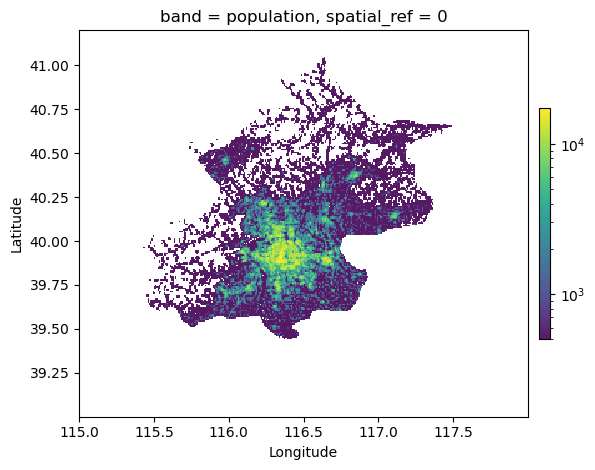

In [26]:
ds = data_corrected.sel(x=slice(115, 118), y=slice(41.2, 39)).where(data_corrected.sel(band="prov_index") ==1).sel(band="population")
fig, ax = plt.subplots()
log_plot(ds, ax =ax, fillna=0, min_val = 500)


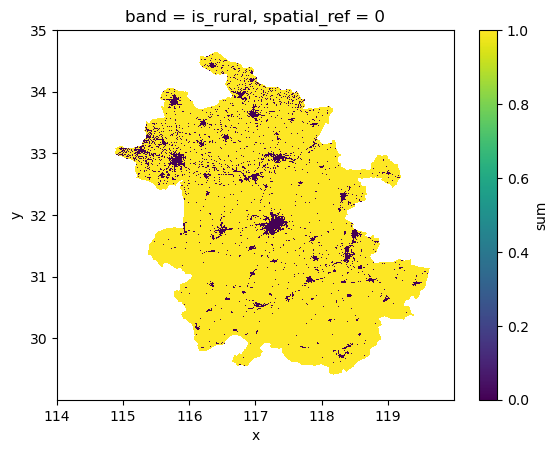

In [27]:
fig, ax = plt.subplots()

ds = data_corrected.sel(x=slice(114, 120), y=slice(35, 29)).where(data_corrected.sel(band="prov_index") ==0).sel(band="is_rural")
ds.plot(ax=ax)

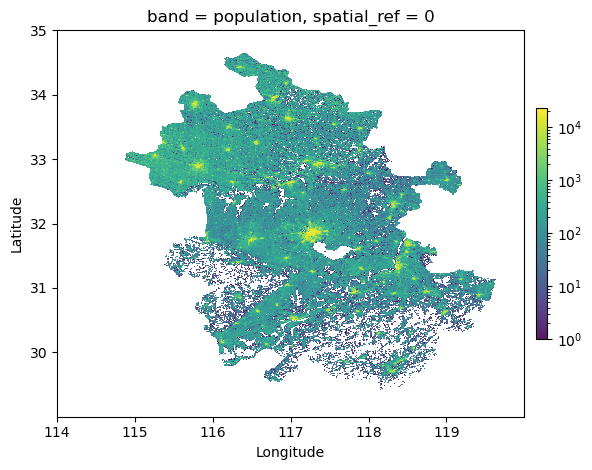

In [28]:
fig, ax = plt.subplots()

ds = data_corrected.sel(x=slice(114, 120), y=slice(35, 29)).where(data_corrected.sel(band="prov_index") ==0).sel(band="population")
log_plot(ds, ax=ax, fillna=0, min_val=1)

In [29]:
import xesmf as xe


In [30]:
high_res_data =  data_corrected.rename({"x":"longitude", "y":"latitude"})
# Create target grid template matching cutout coordinates
target_template = xr.DataArray(
    np.zeros((len(cutout.coords['y']), len(cutout.coords['x']))),
    coords={'y': cutout.coords['y'], 'x': cutout.coords['x']},
    dims=['y', 'x']
).rename({"x":"longitude", "y":"latitude"})

high_res_data.shape, target_template.shape

((3, 4534, 7353), (154, 250))

In [31]:
high_res_data =  data_corrected.rename({"x":"longitude", "y":"latitude"}).sel(band=["population"])
# Create target grid template matching cutout coordinates
target_template = xr.DataArray(
    np.zeros((len(cutout.coords['y']), len(cutout.coords['x']))),
    coords={'y': cutout.coords['y'], 'x': cutout.coords['x']},
    dims=['y', 'x']
).rename({"x":"longitude", "y":"latitude"})

high_res_data.shape, target_template.shape

# Extract bands
population = high_res_data.sel(band='population')


In [ ]:
population.nbytes/1e9

<xarray.DataArray (latitude: 4534, longitude: 7353)> Size: 267MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * latitude     (latitude) float64 36kB 53.55 53.55 53.54 ... 15.8 15.79 15.78
  * longitude    (longitude) float64 59kB 73.5 73.51 73.52 ... 134.8 134.8 134.8
    spatial_ref  int64 8B 0
    band         <U10 40B 'population'
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      sum

In [ ]:

regridder = xe.Regridder(
    population, target_template,
    method='bilinear',
    periodic=False,
)

In [ ]:
high_res_data =  data_corrected.rename({"x":"longitude", "y":"latitude"})
# Create target grid template matching cutout coordinates
target_template = xr.DataArray(
    np.zeros((len(cutout.coords['y']), len(cutout.coords['x']))),
    coords={'y': cutout.coords['y'], 'x': cutout.coords['x']},
    dims=['y', 'x']
).rename({"x":"longitude", "y":"latitude"})

# Extract bands
population = high_res_data.sel(band='population')
is_rural = high_res_data.sel(band='is_rural')
prov_index = high_res_data.sel(band='prov_index')

# Calculate rural population
pop_rural_highres = population.where(is_rural == 1, 0)



# xESMF conservative regridding (BEST - true area weighting)
# Build regridder once (computationally expensive, but reusable)
logger.info("Building xESMF conservative regridder...")

regridder = xe.Regridder(
    population, target_template,
    method='conservative',
    periodic=False,
    ignore_degenerate=True  # Handle polar regions
)
print("computed regridder")
# Apply to all quantities (fast after regridder is built)
pop_total_coarse = regridder(population)
pop_rural_coarse = regridder(pop_rural_highres)

# Calculate rural fraction: rural_pop / total_pop
rural_fraction = pop_rural_coarse / pop_total_coarse.where(pop_total_coarse > 0, np.nan)
rural_fraction = rural_fraction.fillna(0).clip(0, 1)  # Ensure 0-1 range

# Calculate dominant province: weighted_sum / total_pop, then round to integer
prov_index_coarse = (prov_weighted_sum / pop_total_coarse.where(pop_total_coarse > 0, np.nan))
prov_index_coarse = prov_index_coarse.fillna(-1).round().astype(int)

# Validate conservation
total_in = float(population.sum())
total_out = float(pop_total_coarse.sum())
conservation_error = abs(total_out - total_in) / total_in * 100
logger.info(f"Conservation error: {conservation_error:.3f}%")
if conservation_error > 1.0:
    logger.warning(f"Conservation error > 1%: {conservation_error:.2f}%")

regridder.clean_weight_file()  # Clean up temporary files

# Combine into multi-band DataArray
coarse_layouts = xr.concat(
    [pop_total_coarse, pop_rural_coarse, rural_fraction, prov_index_coarse],
    dim='band'
).assign_coords(band=['total', 'rural', 'rural_fraction', 'prov_index'])

: 

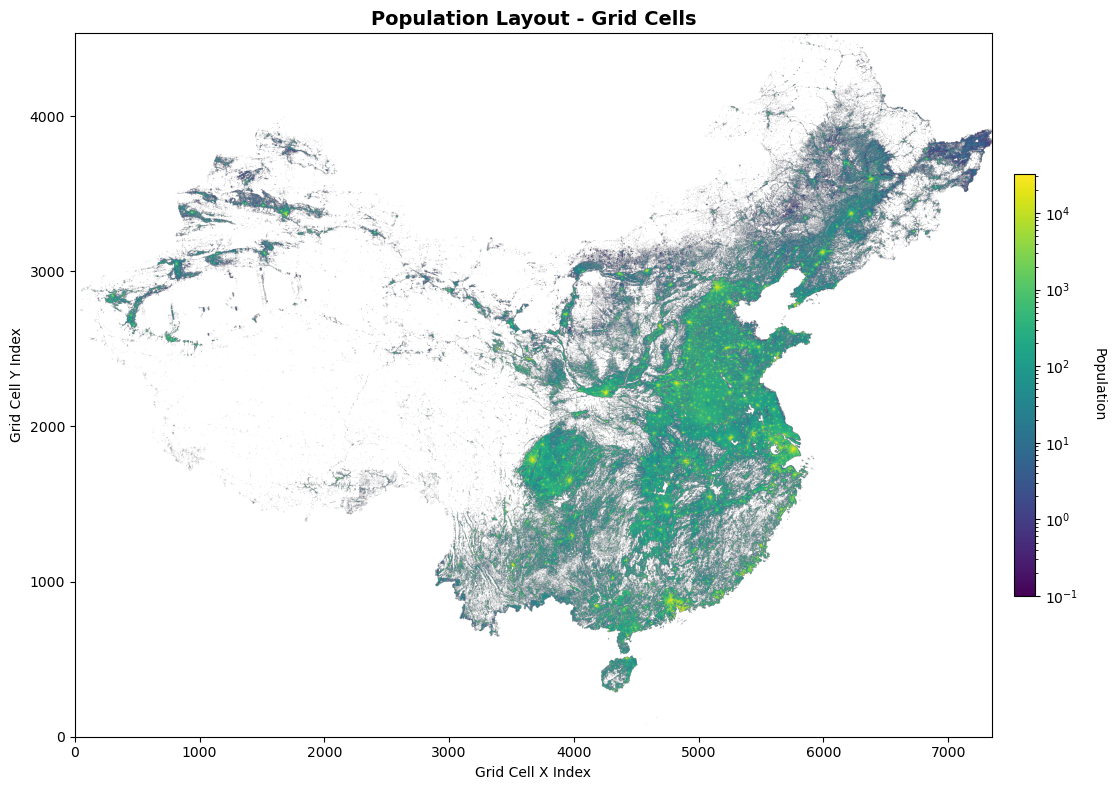

In [ ]:
pop = pop_per_cell_highres.reshape(high_res_pop.shape).squeeze()
pop = pop[::-1,:]
# Create a figure with proper size
fig, ax = plt.subplots(figsize=(12, 8))


im = ax.imshow(pop, 
               norm=LogNorm(vmin=1e-1, vmax=pop.max()), 
               cmap='viridis',
               origin='lower',  # To match geographic orientation
               aspect='auto')

# Add a colorbar with log scale
cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('Population', rotation=270, labelpad=20)

# Set title and labels
ax.set_title('Population Layout - Grid Cells', fontsize=14, fontweight='bold')
ax.set_xlabel('Grid Cell X Index')
ax.set_ylabel('Grid Cell Y Index')

plt.tight_layout()
plt.show()


In [ ]:
I_fast

<Compressed Sparse Row sparse matrix of dtype 'uint8'
	with 13697005 stored elements and shape (33338502, 31)>

In [ ]:
    for prov_name in provinces:
        logger.debug(
            f"The urbanization rate for {prov_name} is {round(urban_frac[prov_name] * 100)}%"
        )

        indicator_prov = prov_data.apply(lambda x: 1.0 if x.name == prov_name else 0.0, axis=1)
        indicator_cells_prov = pd.Series(Iinv.T.dot(indicator_prov))

In [ ]:
pop_per_prov_fast = (I_fast.T) @ high_res_pop.values.ravel()
pop_per_prov_atlite = (atlite_indicator.T) @ test_data.values.ravel()
print(f"\nPopulation per province (using high-res data):")
for i, prov in enumerate(province_shapes.index):
    print(f"{prov}: fast {pop_per_prov_fast[i]:,.0f} atlite {pop_per_prov_atlite[i]:,.0f}")
    



Population per province (using high-res data):
Anhui: fast 60,554,360 atlite 0
Beijing: fast 22,787,576 atlite 0
Chongqing: fast 33,163,510 atlite 0
Fujian: fast 40,730,956 atlite 0
Gansu: fast 24,227,660 atlite 0
Guangdong: fast 133,467,856 atlite 0
Guangxi: fast 51,064,352 atlite 0
Guizhou: fast 40,362,000 atlite 0
Hainan: fast 10,115,131 atlite 0
Hebei: fast 73,886,760 atlite 54
Heilongjiang: fast 26,997,048 atlite 0
Henan: fast 99,920,224 atlite 74
Hubei: fast 56,124,432 atlite 0
Hunan: fast 64,690,580 atlite 0
InnerMongolia: fast 23,174,306 atlite 1
Jiangsu: fast 85,395,616 atlite 0
Jiangxi: fast 45,239,848 atlite 0
Jilin: fast 21,326,280 atlite 0
Liaoning: fast 39,908,128 atlite 0
Ningxia: fast 7,603,830 atlite 0
Qinghai: fast 5,961,328 atlite 0
Shaanxi: fast 39,547,112 atlite 10
Shandong: fast 101,849,976 atlite 0
Shanghai: fast 25,496,752 atlite 0
Shanxi: fast 33,561,408 atlite 165
Sichuan: fast 82,824,944 atlite 0
Tianjin: fast 14,105,821 atlite 0
Tibet: fast 3,990,094 atlite

In [ ]:
grid(high_res_pop)

KeyboardInterrupt: 

In [ ]:
I_hr = atlite.cutout.compute_indicatormatrix(province_shapes.geometry, high_res_pop)  # noqa: E741
I_hr


AttributeError: 'DataArray' object has no attribute 'is_empty'

In [ ]:
# Alternative approach: Use xarray's where() method with indicator matrices
# This is more efficient than multiple clip operations

# First, let's check the shapes and dimensions
print(f"I shape: {I.shape}")
print(f"Iinv shape: {Iinv.shape}")
print(f"Cutout shape: {cutout.shape}")
print(f"Interpolated data shape: {interpolated_data.shape}")
print(f"Interpolated data dims: {interpolated_data.dims}")

# Create a multi-layer dataset where each layer represents one province
province_layers = []
province_names = []

for i, prov_name in enumerate(province_shapes.index):
    print(f"Processing province {i}: {prov_name}")
    
    # Use the i-th column of Iinv.T to get grid cells for this province
    prov_indicator = Iinv.T[:, i]
    
    # Convert sparse matrix to dense array if needed
    if hasattr(prov_indicator, 'toarray'):
        prov_indicator = prov_indicator.toarray().flatten()
    
    # Reshape to match the cutout grid (2D spatial)
    prov_mask = prov_indicator.reshape(cutout.shape)
    
    # Create xarray with same coordinates as squeezed interpolated data
    prov_layer = xr.DataArray(
        prov_mask, 
        coords=interpolated_data.coords,
        dims=interpolated_data.dims
    )
    
    # Multiply by interpolated population data to get population only in this province
    clipped_layer = interpolated_data * prov_layer
    
    province_layers.append(clipped_layer)
    province_names.append(prov_name)
    
    # Only process first 3 provinces for testing
    if i >= 2:
        break

# Combine all province layers into a single dataset with a new 'province' dimension
province_dataset = xr.concat(province_layers, dim='province')
province_dataset = province_dataset.assign_coords(province=province_names)

print(f"Created multi-layer dataset with shape: {province_dataset.shape}")
print(f"Provinces: {list(province_dataset.province.values)}")

I shape: (38500, 31)
Iinv shape: (31, 38500)
Cutout shape: (154, 250)
Interpolated data shape: (154, 250)
Interpolated data dims: ('y', 'x')
Processing province 0: Anhui
Processing province 1: Beijing
Processing province 2: Chongqing
Processing province 1: Beijing
Processing province 2: Chongqing
Created multi-layer dataset with shape: (3, 154, 250)
Provinces: ['Anhui', 'Beijing', 'Chongqing']
Created multi-layer dataset with shape: (3, 154, 250)
Provinces: ['Anhui', 'Beijing', 'Chongqing']


In [ ]:
# Now you can easily access any province layer and plot it
# Example: Plot a few provinces
sample_provinces = ['Beijing', 'Shanghai', 'Guangdong'] if all(p in province_names for p in ['Beijing', 'Shanghai', 'Guangdong']) else province_names[:3]

for prov in sample_provinces:
    if prov in province_dataset.province.values:
        prov_data_layer = province_dataset.sel(province=prov)
        log_plot(prov_data_layer, label=f'Population ({prov})')

# You can also do operations across all provinces at once:
# Total population per province
total_pop_by_province = province_dataset.sum(dim=['x', 'y'])
print("Total population by province:")
for i, prov in enumerate(province_dataset.province.values):
    print(f"{prov}: {total_pop_by_province[i].values:,.0f}")

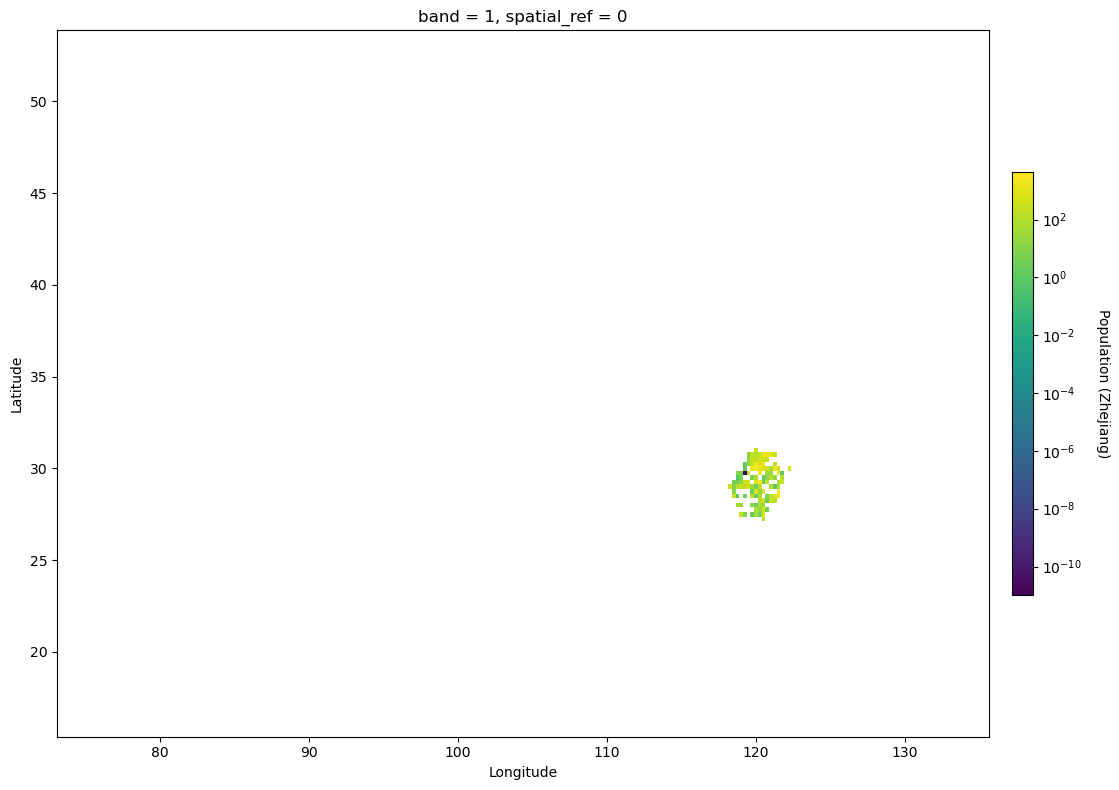

In [ ]:

clipped_data = interpolated_data.rio.clip([prov_data.loc[prov].geometry], prov_data.crs, drop=False)
log_plot(clipped_data, label=f'Population ({prov})')

In [ ]:
prov

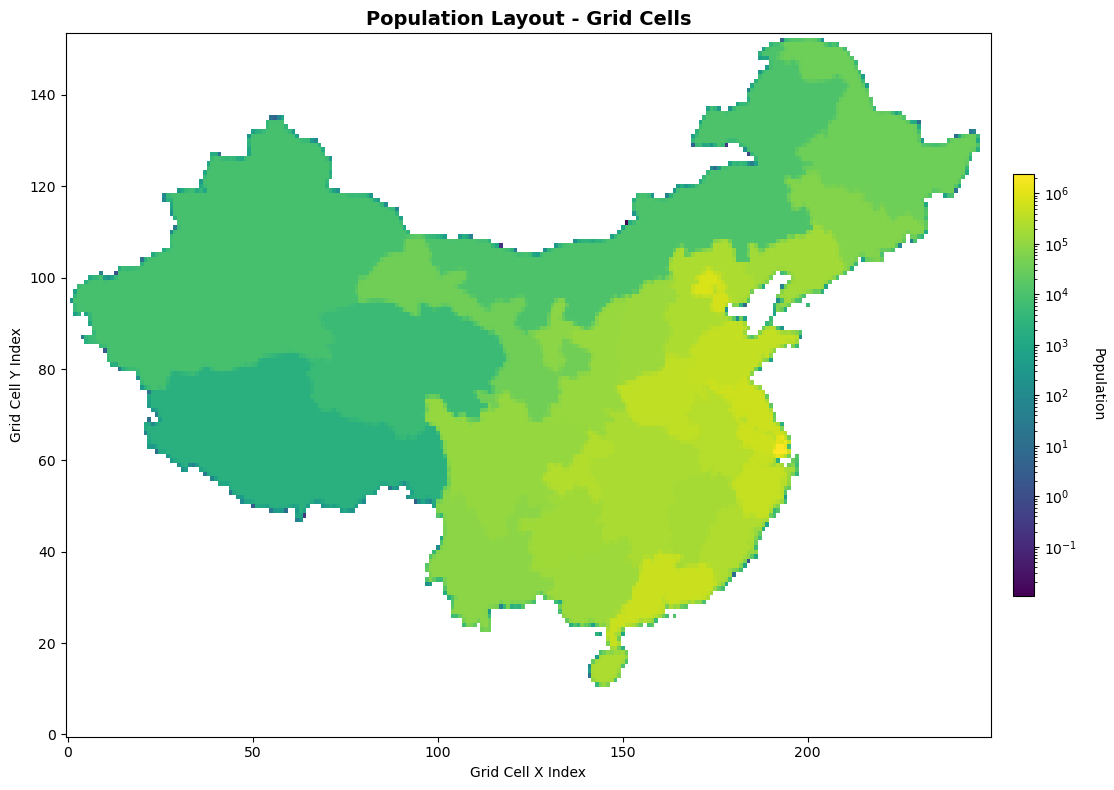

In [ ]:
# Create a figure with proper size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with log scale and colorbar
data = I.dot(population_provs).reshape(154, 250)
im = ax.imshow(data, 
               norm=LogNorm(vmin=data[data > 0].min(), vmax=data.max()), 
               cmap='viridis',
               origin='lower',  # To match geographic orientation
               aspect='auto')

# Add a colorbar with log scale
cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('Population', rotation=270, labelpad=20)

# Set title and labels
ax.set_title('Population Layout - Grid Cells', fontsize=14, fontweight='bold')
ax.set_xlabel('Grid Cell X Index')
ax.set_ylabel('Grid Cell Y Index')

plt.tight_layout()
plt.show()